In [1]:
# import torch
# import torchvision

# Perform OCR on image

import matplotlib.pyplot as plt
import os
import json
import pandas as pd
# from sklearn.cluster import DBSCAN
# from sklearn import metrics
# from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
def normalize_bbox(bbox, width, height):
     return [
         int(1000 * (bbox[0] / width)),
         int(1000 * (bbox[1] / height)),
         int(1000 * (bbox[2] / width)),
         int(1000 * (bbox[3] / height)),
     ]

In [3]:
def CORD_train(directory):
  ####################
  # cord Dataset
  ####################

  # Process the Raw Labelled cord Data
  # Data consisting of 112 annotated medical documents
#   directory = 'CORD/train/json'
  
  # iterate over files
  words = []
  bbox = []
  labels = []
  for filename in sorted(os.listdir(directory)):
      f = os.path.join(directory, filename)
      # checking if it is a file
      if os.path.isfile(f):
        dataraw = open(f)
        jdata = json.load(dataraw)
        height = jdata['meta']['image_size']['height']
        width = jdata['meta']['image_size']['width']
        word = []
        boxes = []
        label = []
        for feature in jdata['valid_line']:
          for ele in feature['words']:
              txt = ele['text']

              # bounding box - (upper left, lower right) upper left is (x1, y3)
              # and the lower right is (x3, y1)
              x1 = ele['quad']['x1']
              y1 = ele['quad']['y1']
              x3 = ele['quad']['x3']
              y3 = ele['quad']['y3']
              
              box = [x1, y1, x3, y3]
              box = normalize_bbox(box, width=width, height=height) 

              if len(txt) < 1: 
                continue
              if min(box) < 0 or max(box) > 1000: # another bug in which a box had -4
                continue
              if ((box[3] - box[1]) < 0) or ((box[2] - box[0]) < 0): # another bug in which a box difference was -12
                continue
              # ADDED

              word.append(txt)
              boxes.append(box) 
              label.append(feature['category'])
        words.append(word) 
        bbox.append(boxes) 
        labels.append(label)
  return words,labels,bbox 

In [4]:
token_train, label_train, boxe_train = CORD_train("CORD/train/json")
token_test, label_test, boxe_test= CORD_train("CORD/test/json")
token_dev, label_dev, boxe_dev = CORD_train("CORD/dev/json")

In [5]:
label_train

[['menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.cnt',
  'menu.nm',
  'menu.nm',
  'menu.nm',
  'menu.price',
  'menu.cnt',
  'menu.nm',
  'menu.nm',
  'menu.nm',
  'menu.price',
  'menu.cnt',
  'menu.nm',
  'menu.nm',
  'menu.price',
  'menu.cnt',
  'menu.nm',
  'menu.nm',
  'menu.nm',
  'menu.price',
  'menu.cnt',
  'menu.nm',
  'menu.nm',
  'menu.nm',
  'menu.price',
  'menu.cnt',
  'menu.nm',
  'menu.nm',
  'menu.nm',
  'menu.price',
  'menu.cnt',
  'menu.nm',
  'menu.nm',
  'menu.nm',
  'menu.price',
  'menu.cnt',
  'menu.nm',
  'menu.nm',
  'menu.price',
  'menu.cnt',
  'menu.nm',
  'menu.nm',
  'menu.price',
  'menu.cnt',
  'menu.nm',
  'menu.nm',
  'menu.nm',
  'menu.price',
  'menu.cnt',
  'menu.nm',
  'menu.nm',
 

In [6]:
def preprossing(label):
    for i in range(len(label)):
        for j in range(len(label[i])):
            if (label[i][j] == "menu.nm") | (label[i][j] == 'menu.nm') | (label[i][j] == 'menu.sub_nm') | (label[i][j] == 'void_menu.nm') | (label[i][j] == 'menu.vatyn'):
                label[i][j] = 0
            elif (label[i][j] == 'menu.cnt') | (label[i][j] == 'total.menuqty_cnt') | (label[i][j] == 'menu.sub_cnt') | (label[i][j] == 'total.menutype_cnt') | (label[i][j] == 'menu.num'):
                label[i][j] = 2   
            else:
                label[i][j] = 1
    return label                

In [7]:
label_train=preprossing(label_train)
label_test=preprossing(label_test)
label_dev=preprossing(label_dev)

In [8]:
def cage_data(word,label,box):
    words=[item for sublist in word for item in sublist]
    bbox=[item for sublist in box for item in sublist]
    labels=[item for sublist in label for item in sublist]
    return words,labels,bbox

In [9]:
lf=8
# dic={242:4,1297:20,2587:40}
# l_ocr = ocr_train[:lf]
# u_ocr = ocr_train[lf:]

In [10]:
token_train_lab=token_train[:lf]
label_train_lab=label_train[:lf]
boxe_train_lab=boxe_train[:lf]
token_train_unl=token_train[lf:]
label_train_unl=label_train[lf:]
boxe_train_unl=boxe_train[lf:]

In [11]:
cage_token_train_lab, cage_label_train_lab, cage_boxe_train_lab=cage_data(token_train_lab, label_train_lab, boxe_train_lab)
cage_token_train_unl, cage_label_train_unl, cage_boxe_train_unl=cage_data(token_train_unl, label_train_unl, boxe_train_unl)
cage_token_test, cage_label_test, cage_boxe_test=cage_data(token_test, label_test, boxe_test)
cage_token_dev, cage_label_dev, cage_boxe_dev=cage_data(token_dev, label_dev, boxe_dev)

In [12]:
import enum
# Create Label Class
class ClassLabels(enum.Enum):
    # menu.cnt = 1
    # menu.discountprice = 2
    # menu.etc = 3
    # menu.itemsubtotal = 4
    # menu.nm = 5
    # menu.num = 6
    # menu.price = 7
    # menu.sub_cnt = 8
    # menu.sub_etc = 9
    # menu.sub_nm = 10
    # menu.sub_price = 11 
    # menu.sub_unitprice = 12
    # menu.unitprice = 13
    # menu.vatyn = 14
    # sub_total.discount_price = 15
    # sub_total.etc = 16
    # sub_total.othersvc_price = 17
    # sub_total.service_price = 18
    # sub_total.subtotal_price = 19
    # sub_total.tax_price = 20
    # total.cashprice = 21
    # total.changeprice = 22
    # total.creditcardprice = 23
    # total.emoneyprice = 24
    # total.menuqty_cnt = 25
    # total.menutype_cnt = 26
    # total.total_etc = 27
    # total.total_price = 28
    # void_menu.nm = 29
    # void_menu.price = 30
    MENU = 0
    PRICE = 1
    # CASH = 3
    QUANTITY = 2
  

THRESHOLD = 0.8

texttrigger = {"total","tax","price","discount","non","change","subtotal","%",",",".00",".000",".0",".0000","Kembali","cash","card","amount","tendered","net","sales",}
fieldtrigger = {"qty","1.00xITEMS","x","X","(Qty"}
fieldtriggerz = {"qty","item","items","x"}


from spear4HighFidelity.spear.labeling import labeling_function, ABSTAIN, preprocessor, continuous_scorer
import re

@preprocessor()
def convert_to_lower(x):
    return x.lower().strip()
    
@labeling_function(resources=dict(keywords=texttrigger),pre=[convert_to_lower],label=ClassLabels.PRICE)
def LF1(x,**kwargs):    
    if (len(kwargs["keywords"].intersection(x.split())) > 0):
        return ClassLabels.PRICE
    else:
        return ABSTAIN

@labeling_function(resources=dict(keywords=fieldtrigger),pre=[convert_to_lower],label=ClassLabels.QUANTITY)
def LF2(x,**kwargs):
    if (len(kwargs["keywords"].intersection(x.split())) > 0):
        return ClassLabels.QUANTITY
    else:
        return ABSTAIN

@labeling_function(resources=dict(keywords=fieldtriggerz),pre=[convert_to_lower],label=ClassLabels.QUANTITY)
def LF3(x,**kwargs):
    for pattern in kwargs["keywords"]:    
        if re.search(pattern,x, flags= re.I):
            return ClassLabels.QUANTITY
    return ABSTAIN

@labeling_function(pre=[convert_to_lower],label=ClassLabels.PRICE)
def LF4(x):
    if x.isnumeric() and int(x)>=10:
        return ClassLabels.PRICE
    else:
        return ABSTAIN

@labeling_function(pre=[convert_to_lower],label=ClassLabels.QUANTITY)
def LF5(x):
    if x.isnumeric() and int(x)<5:
        return ClassLabels.QUANTITY
    else:
        return ABSTAIN        

@labeling_function(resources=dict(keywords=texttrigger),pre=[convert_to_lower],label=ClassLabels.PRICE)
def LF6(x,**kwargs):
    for pattern in kwargs["keywords"]:    
        if re.search(pattern,x, flags= re.I):
            return ClassLabels.PRICE
    return ABSTAIN

#  and LF1(x)==ABSTAIN and LF2(x)==ABSTAIN and LF3(x)==ABSTAIN and LF4(x)==ABSTAIN and LF5(x)==ABSTAIN and LF6(x)==ABSTAIN     

@labeling_function(pre=[convert_to_lower],label=ClassLabels.MENU)
def LF7(x,**kwargs):    
    if x.isalnum() and LF1(x)==(None, None)  and LF5(x)==(None, None):
        return ClassLabels.MENU
    else:
        return ABSTAIN

In [13]:
from spear4HighFidelity.spear.labeling import LFSet

LFS = [LF1,
       LF2,
       LF3,
       LF4,
       LF5,
       LF6,
       LF7
      ]

rules = LFSet("CORD_LF")
rules.add_lf_list(LFS)

In [14]:
cage_label_train_unl

[2,
 1,
 1,
 0,
 0,
 2,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 2,
 1,
 1,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 0,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [15]:
# Test Run
from spear4HighFidelity.spear.labeling import PreLabelsWithContext
import numpy as np

X = np.array(cage_token_train_unl)
bbox = np.array(cage_boxe_train_unl)
# bbox
Y = np.array(cage_label_train_unl)
# print(Y)

R = np.zeros((X.shape[0],len(rules.get_lfs())))

##############################
# Modified Prelabels
##############################
cord_noisy_labels = PreLabelsWithContext(name="cord",
                            data=X,
                            # data_feats=bbox,
                            gold_labels=Y,
                            rules=rules,
                            labels_enum=ClassLabels,num_classes=3)

L,S = cord_noisy_labels.get_labels()

  0%|          | 0/19036 [00:00<?, ?it/s]

100%|██████████| 19036/19036 [00:00<00:00, 43933.16it/s]


In [17]:
#234 -> 1%     
#311 -> 1%
#1012 -> 5%
#1994 -> 10%
# Preprocessing
labelling_fac=1994
X_T = np.array(cage_token_train_lab)
Y_T = np.array(cage_label_train_lab) 
X_U = np.array(cage_token_train_unl)
Y_U = np.array(cage_label_train_unl)
bbox_l = np.array(cage_boxe_train_lab)
test_size = len(X_T)
U_size = len(X_U)
bbox_U = np.array(cage_boxe_train_unl)
n_lfs = len(rules.get_lfs())


# print(n_lfs)

# Paths
path_json = 'Paths/cord_json_trail_1%.json'
T_path_pkl = 'Paths/cord_pickle_trail_T_1%.pkl' #test data - have true labels
U_path_pkl = 'Paths/cord_pickle_trail_U_1%.pkl' #unlabelled data - don't have true labels

log_path_cage_1 = 'Paths/cord_trail_log_1_1%.txt' #cage is an algorithm, can be found below
params_path = 'Paths/cord_trail_params_1%.pkl' #file path to store parameters of Cage, used below

# Generate Noisy labels
from spear4HighFidelity.spear.labeling import PreLabels

cord_noisy_labels_lab = PreLabels(name="cord",
                               data=X_T,
                               gold_labels=Y_T,
                               data_feats=bbox_l,
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3)
L_lab,S_lab = cord_noisy_labels_lab.get_labels()                               
cord_noisy_labels_lab.generate_pickle(T_path_pkl)

cord_noisy_labels.generate_json(path_json) #generating json files once is enough

cord_noisy_labels_unl = PreLabels(name="cord",
                               data=X_U,
                               data_feats=bbox_U,
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3) #note that we don't pass gold_labels here, for the unlabelled data
L_unl,S_unl = cord_noisy_labels_unl.get_labels()
cord_noisy_labels_unl.generate_pickle(U_path_pkl)

100%|██████████| 19036/19036 [00:00<00:00, 43445.91it/s]


In [20]:
# Preprocessing
X_TI = np.array(cage_token_test)
Y_TI = np.array(cage_label_test)
X_D = np.array(cage_token_dev)
Y_D = np.array(cage_label_dev)
bbox_TI = np.array(cage_boxe_test) 
bbox_D = np.array(cage_boxe_dev) 
test_size = len(X_TI)
print(Y_TI.shape)
Z_size = len(X_D)
# n_lfs = len(rules.get_lfs())

# print(n_lfs)

# Paths
path_json = 'Paths/cord_json.json'
TI_path_pkl = 'Paths/cord_test_pickle_trail_T_1%.pkl' #test data - have true labels
Z_path_pkl = 'Paths/cord_dev_pickle_trail_U_1%.pkl' #unlabelled data - don't have true labels

# log_path_cage_1 = 'Cages_Paths/cord_log_1.txt' #cage is an algorithm, can be found below
# params_path = 'Cages_Paths/cord_params.pkl' #file path to store parameters of Cage, used below


# Generate Noisy labels
from spear4HighFidelity.spear.labeling import PreLabels

cord_noisy_labels_test = PreLabels(name="cord",
                               data=X_TI,
                               gold_labels=Y_TI,
                               data_feats=bbox_TI,
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3)
L_test,S_test = cord_noisy_labels_test.get_labels()                               
cord_noisy_labels_test.generate_pickle(TI_path_pkl)

cord_noisy_labels.generate_json(path_json) #generating json files once is enough

cord_noisy_labels_val = PreLabels(name="cord",
                               data=X_D,
                               gold_labels=Y_D,
                               data_feats=bbox_D,
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3) #note that we don't pass gold_labels here, for the unlabelled data
cord_noisy_labels_val.generate_pickle(Z_path_pkl)
L_val,S_val = cord_noisy_labels_val.get_labels()

(2354,)


100%|██████████| 2186/2186 [00:00<00:00, 44798.15it/s]


In [21]:
from spear4HighFidelity.spear.cage import Cage
cage = Cage(path_json = path_json, n_lfs = n_lfs)

probs = cage.fit_and_predict_proba(path_pkl = U_path_pkl, path_test = T_path_pkl, path_log = log_path_cage_1, \
                                   qt = 0.9, qc = np.array([0.85]), metric_avg = ['micro'], n_epochs = 200, lr = 0.01)
labels = np.argmax(probs, 1)
print("probs shape: ", probs.shape)
print("labels shape: ",labels.shape)

100%|██████████| 200/200 [00:10<00:00, 19.42it/s]

final_test_accuracy_score: 0.8343558282208589
test_average_metric: micro	final_test_f1_score: 0.8343558282208589
probs shape:  (19036, 3)
labels shape:  (19036,)


In [22]:
probs

array([[0.19096412, 0.00893274, 0.05427841],
       [0.0782186 , 1.37212944, 0.0550926 ],
       [0.0782186 , 1.37212944, 0.0550926 ],
       ...,
       [0.0782186 , 1.37212944, 0.0550926 ],
       [0.19142546, 0.24199879, 0.01065608],
       [0.0782186 , 1.37212944, 0.0550926 ]])

In [23]:
from spear4HighFidelity.spear.labeling import PreLabels
import numpy as np

R = np.zeros((X.shape[0],len(rules.get_lfs())))

cord_noisy_labels = PreLabels(name="cord",
                               data=X,
                               data_feats = bbox,
                               gold_labels=Y,
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3)
L,S = cord_noisy_labels.get_labels()

100%|██████████| 19036/19036 [00:00<00:00, 43803.71it/s]


In [24]:
from spear4HighFidelity.spear.labeling import LFAnalysis
analyse = cord_noisy_labels.analyse_lfs(plot=False)

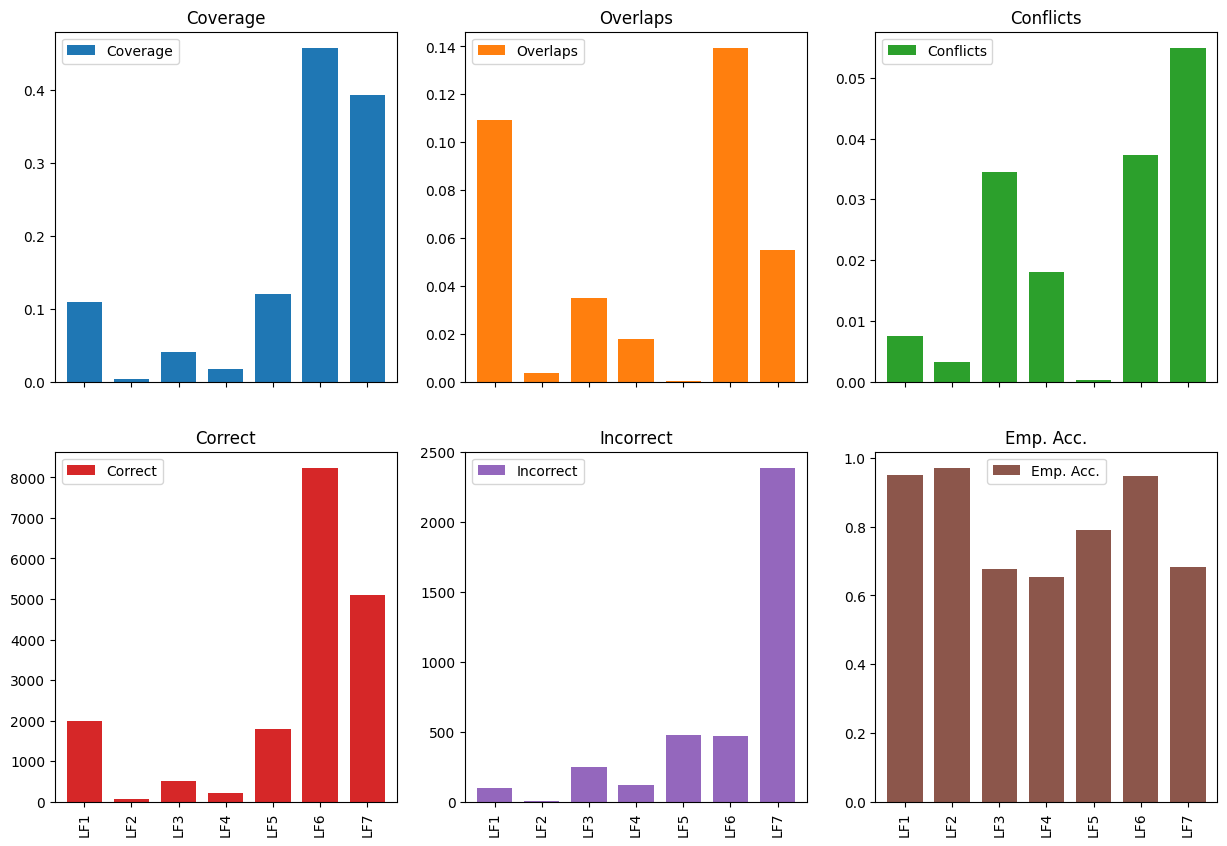

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LF1,"[-1.0, 1.0]",0.109424,0.109424,0.007512,1982,101,0.951512
LF2,"[-1.0, 2.0]",0.003467,0.003467,0.003152,64,2,0.969697
LF3,"[-1.0, 2.0]",0.040292,0.034776,0.034461,520,247,0.677966
LF4,"[-1.0, 1.0]",0.017966,0.017966,0.017966,224,118,0.654971
LF5,"[-1.0, 2.0]",0.119458,0.000263,0.000263,1796,478,0.789798
LF6,"[-1.0, 1.0]",0.456661,0.139210,0.037298,8224,469,0.946049
LF7,"[-1.0, 0.0]",0.392414,0.054843,0.054843,5089,2381,0.681258


In [25]:
analyse
from spear4HighFidelity.spear.labeling import LFAnalysis

analyse = cord_noisy_labels.analyse_lfs(plot=True)

result = analyse.head(16)
display(result)

Pickle for JL layoutlm

In [26]:
import json
import pandas as pd
import numpy as np
import os
from tqdm import tqdm_notebook as tqdm

In [27]:
L_w=[]
for i in range(len(token_train)):
    cord_noisy_labels_test = PreLabels(name="cord",
                               data=np.array(token_train[i]),
                               gold_labels=np.array(label_train[i]),
                               data_feats=np.array(list(boxe_train[i])),
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3)
    L,S = cord_noisy_labels_test.get_labels()
    L_w.append(L)      

100%|██████████| 11/11 [00:00<00:00, 36072.98it/s]


In [28]:
for i in range(len(L_w)):
    for j in range(len(L_w[i])):
        for k in range(len(L_w[i][j])):
            if L_w[i][j][k]==None:
                L_w[i][j][k]=-1

In [29]:
L_w_test=[]
for i in range(len(token_test)):
    cord_noisy_labels_test = PreLabels(name="cord",
                               data=np.array(token_test[i]),
                               gold_labels=np.array(label_test[i]),
                               data_feats=np.array(list(boxe_test[i])),
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3)
    L,S = cord_noisy_labels_test.get_labels()
    L_w_test.append(L)      

100%|██████████| 59/59 [00:00<00:00, 36402.46it/s]


In [30]:
for i in range(len(L_w_test)):
    for j in range(len(L_w_test[i])):
        for k in range(len(L_w_test[i][j])):
            if L_w_test[i][j][k]==None:
                L_w_test[i][j][k]=-1

In [31]:
L_w_dev=[]
for i in range(len(token_dev)):
    cord_noisy_labels_test = PreLabels(name="cord",
                               data=np.array(token_dev[i]),
                               gold_labels=np.array(label_dev[i]),
                               data_feats=np.array(list(boxe_dev[i])),
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3)
    L,S = cord_noisy_labels_test.get_labels()
    L_w_dev.append(L)
          

100%|██████████| 32/32 [00:00<00:00, 37585.47it/s]


In [32]:
for i in range(len(L_w_dev)):
    for j in range(len(L_w_dev[i])):
        for k in range(len(L_w_dev[i][j])):
            if L_w_dev[i][j][k]==None:
                L_w_dev[i][j][k]=-1

In [33]:
def org_lab(label):
    for i in range(len(label)):
        for j in range(len(label[i])):
            if (label[i][j] == 0):
                label[i][j] = 'MENU'
            elif (label[i][j] == 2):
                label[i][j] = 'QUANTITY'    
            else:
                label[i][j] = 'PRICE'
    return label            

In [34]:
label_train_lab=org_lab(label_train_lab)
label_train_unl=org_lab(label_train_unl)
label_test=org_lab(label_test)
label_dev=org_lab(label_dev)

In [35]:
label_train_lab

[['QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'QUANTITY',
  'MENU',
  'MENU',
  'MENU',
  'PRICE',
  'QUANTITY',
  'MENU',
  'MENU',
  'MENU',
  'PRICE',
  'QUANTITY',
  'MENU',
  'MENU',
  'PRICE',
  'QUANTITY',
  'MENU',
  'MENU',
  'MENU',
  'PRICE',
  'QUANTITY',
  'MENU',
  'MENU',
  'MENU',
  'PRICE',
  'QUANTITY',
  'MENU',
  'MENU',
  'MENU',
  'PRICE',
  'QUANTITY',
  'MENU',
  'MENU',
  'MENU',
  'PRICE',
  'QUANTITY',
  'MENU',
  'MENU',
  'PRICE',
  'QUANTITY',
  'MENU',
  'MENU',
  'PRICE',
  'QUANTITY',
  'MENU',
  'MENU',
  'MENU',
  'PRICE',
  'QUANTITY',
  'MENU',
  'MENU',
  'PRICE',
  'QUANTITY',
  'MENU',
  'MENU',
  'PRICE',
  'QUANTITY',
  'MENU',
  'MENU',
  'MENU',
  'PRICE',
  'QUANTITY',
  'MENU',
  '

In [36]:
token_train_lab=np.array(token_train_lab)
label_train_lab=np.array(label_train_lab)
boxe_train_lab=np.array(boxe_train_lab)
L_lab=np.array(L_w)[:lf]

/tmp/ipykernel_3169998/3735515616.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  token_train_lab=np.array(token_train_lab)
/tmp/ipykernel_3169998/3735515616.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_train_lab=np.array(label_train_lab)
/tmp/ipykernel_3169998/3735515616.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

In [37]:
token_train_unl=np.array(token_train_unl)
label_train_unl=np.array(label_train_unl)
boxe_train_unl=np.array(boxe_train_unl)
L_unl=np.array(L_w)[lf:]

/tmp/ipykernel_3169998/2358246700.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  token_train_unl=np.array(token_train_unl)
/tmp/ipykernel_3169998/2358246700.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_train_unl=np.array(label_train_unl)
/tmp/ipykernel_3169998/2358246700.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

In [38]:
token_train_dev=np.array(token_dev)
label_train_dev=np.array(label_dev)
boxe_train_dev=np.array(boxe_dev)
L_dev=np.array(L_w_dev)

/tmp/ipykernel_3169998/2355019901.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  token_train_dev=np.array(token_dev)
/tmp/ipykernel_3169998/2355019901.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_train_dev=np.array(label_dev)
/tmp/ipykernel_3169998/2355019901.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxe

In [39]:
token_train_test=np.array(token_test)
label_train_test=np.array(label_test)
boxe_train_test=np.array(boxe_test)
L_test=np.array(L_w_test)

/tmp/ipykernel_3169998/3368033224.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  token_train_test=np.array(token_test)
/tmp/ipykernel_3169998/3368033224.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_train_test=np.array(label_test)
/tmp/ipykernel_3169998/3368033224.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  

In [40]:
import pickle
with open('Paths/cord_trail_train_jl_1%.pkl', 'wb') as t:
    pickle.dump(np.array([token_train_lab, label_train_lab, boxe_train_lab,L_lab]), t)
with open('Paths/cord_trail_train_u_jl_1%.pkl', 'wb') as t:
    pickle.dump(np.array([token_train_unl, label_train_unl, boxe_train_unl,L_unl]), t)    
with open('Paths/cord_trail_val_jl_1%.pkl', 'wb') as t:
    pickle.dump(np.array([token_train_dev, label_train_dev, boxe_train_dev,L_dev]), t)
with open('Paths/cord_trail_test_jl_1%.pkl', 'wb') as t:
    pickle.dump(np.array([token_train_test, label_train_test, boxe_train_test,L_test]), t)

In [41]:
import pickle
pat="Paths/cord_trail_train_jl_1%.pkl"
train = pickle.load(open(pat, 'rb'))
train

array([[list(['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', '1', 'Nasi', 'Campur', 'Bali', '75,000', '1', 'Bbk', 'Bengil', 'Nasi', '125,000', '1', 'MilkShake', 'Starwb', '37,000', '1', 'Ice', 'Lemon', 'Tea', '24,000', '1', 'Nasi', 'Ayam', 'Dewata', '70,000', '3', 'Free', 'Ice', 'Tea', '0', '1', 'Organic', 'Green', 'Sa', '65,000', '1', 'Ice', 'Tea', '18,000', '1', 'Ice', 'Orange', '29,000', '1', 'Ayam', 'Suir', 'Bali', '85,000', '2', 'Tahu', 'Goreng', '36,000', '2', 'Tempe', 'Goreng', '36,000', '1', 'Tahu', 'Telor', 'Asin', '40,000.', '1', 'Nasi', 'Goreng', 'Samb', '70,000', '3', 'Bbk', 'Panggang', 'Sam', '366,000', '1', 'Ayam', 'Sambal', 'Hija', '92,000', '2', 'Hot', 'Tea', '44,000', '1', 'Ice', 'Kopi', '32,000', '1', 'Tahu', 'Telor', 'Asin', '40,000', '1', 'Free', 'Ice', 'Tea', '0', '1', 'Bebek', 'Street', '44,000', '1', 'Ice', 'Tea', 'Tawar', '18,000', 'Sub-Total', '1,346,000', 'Service', '100,950', 'PB1', '144,695', 'Ro